This code is based on the sample code provided by traker at
https://trak.readthedocs.io/en/latest/quickstart.html

and the hugging face diffusers training code since their API does not let you get the loss directly
https://github.com/huggingface/diffusers/blob/v0.30.3/examples/text_to_image/train_text_to_image.py
        

In [21]:
import torch
from pathlib import Path

CONVERT_SAFETENSORS_TO_CKPT = False
CUDA = True

#ckpt_files = list(Path('./checkpoints').rglob('*.pt'))
#ckpts = [torch.load(ckpt, map_location='cpu') for ckpt in ckpt_files]

filename = "../FineTuned-SD1-cifar10/unet/diffusion_pytorch_model.safetensors"
#s/o https://gist.github.com/madaan/6c9be9613e6760b7dee79bdfa621fc0f
if CONVERT_SAFETENSORS_TO_CKPT:
    from safetensors.torch import load_file
    ckpt = load_file(filename)
    torch.save(ckpt, filename.replace(".safetensors", ".bin"))

ckpt_filename = filename.replace(".safetensors", ".bin")
ckpt = torch.load(ckpt_filename)

/tmp/ipykernel_480157/3652397506.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_filename)


In [22]:
IS_WINDOWS = False
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel
from torchvision import transforms
import os
if IS_WINDOWS: 
    p = "..\\FineTuned-SD1-cifar10"
else: #Assume UNIX-based
    p = "../FineTuned-SD1-cifar10"
print(os.path.isdir(p))

tokenizer = CLIPTokenizer.from_pretrained(
    p, subfolder="tokenizer",
)

text_encoder = CLIPTextModel.from_pretrained(
    p, subfolder="text_encoder",
)
vae = AutoencoderKL.from_pretrained(
    p, subfolder="vae",
)

unet = UNet2DConditionModel.from_pretrained(
     p, subfolder="unet",
)

text_encoder.to("cuda")
vae.to("cuda")
unet.to("cuda")

# Freeze vae and text_encoder
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
#unet.train()


# Dataloader
from datasets import load_dataset
from torch.utils.data import DataLoader

#https://huggingface.co/datasets/

dataset_name = "uoft-cs/cifar10"
dataset = load_dataset(dataset_name, split="train")

image_column = "img"
caption_column = "label_txt"

#dataset = dataset.rename_column("img", "image")
print(dataset)
cl = dataset.features['label']
print(type(cl))

def convertLabel(x):
    x['label_txt'] = cl.int2str(x['label'])
    return x

dataset = dataset.map(convertLabel)

dataset = dataset.remove_columns(column_names=["label"])

train_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )


# Preprocessing the datasets.
# We need to tokenize input captions and transform the images.
def tokenize_captions(examples, is_train=True):
    inputs = tokenizer(
        examples[caption_column], max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
    return inputs.input_ids

def preprocess_train(examples):
        images = [image.convert("RGB") for image in examples[image_column]]
        examples["pixel_values"] = [train_transforms(image) for image in images]
        examples["input_ids"] = tokenize_captions(examples)
        return examples

#dataset = dataset.with_format("torch")
print(dataset)
train_dataset = dataset.with_transform(preprocess_train)

def collate_fn(examples):
        pixel_values = torch.stack([example["pixel_values"] for example in examples])
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
        input_ids = torch.stack([example["input_ids"] for example in examples])
        return {"pixel_values": pixel_values, "input_ids": input_ids}

# DataLoaders creation:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=False,
    collate_fn=collate_fn,
    batch_size=1,
)

True
Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})
<class 'datasets.features.features.ClassLabel'>
Dataset({
    features: ['img', 'label_txt'],
    num_rows: 50000
})


In [23]:
from trak import TRAKer
from SD1ModelOutput import SD1ModelOutput

traker = TRAKer(model=unet,
                task=SD1ModelOutput,
                train_set_size=len(train_dataloader.dataset),
                proj_max_batch_size=8, #Default 32, requires an A100 apparently
                #proj_dim=1024,
                )

INFO:TRAK:Using ChunkedCudaProjector with2 chunks of sizes[518204160, 341316804].
INFO:STORE:Existing model IDs in /home/joy/Lboro/CodeServer/git/Data-Attribution-for-Stable-Diffusion/TRAK/trak_results: [0]
INFO:STORE:Model IDs that have been finalized: [0]
INFO:STORE:Existing TRAK scores:
INFO:STORE:quickstart: /home/joy/Lboro/CodeServer/git/Data-Attribution-for-Stable-Diffusion/TRAK/trak_results/scores/quickstart.mmap


In [24]:
#Scoop whatever VRAM we can because this is going to be a tight fit
import gc
gc.collect()
torch.cuda.empty_cache()

In [25]:
from tqdm import tqdm

UPDATE_FEATURIZATION = False

#for model_id, ckpt in enumerate(ckpts): #tqdm

# TRAKer loads the provided checkpoint and also associates

# the provided (unique) model_id with the checkpoint.
model_id = 0
traker.load_checkpoint(ckpt, model_id=model_id)
weight_dtype = torch.float32

if UPDATE_FEATURIZATION:
    for batch in tqdm(train_dataloader):
        if CUDA:
            batch = [x.cuda() for y,x in batch.items()]
        else:
            batch = [x for y,x in batch.items()]
        image = batch[0]
        tokens = batch[1]
        # Convert images to latent space
        latents = vae.encode(image.to(weight_dtype)).latent_dist.sample()
        latents = latents * vae.config.scaling_factor
        encoder_hidden_states = text_encoder(tokens, return_dict=False)[0]

        batch = [latents, encoder_hidden_states]

        #batch = [x.cuda() for y,x in batch.items()]

        # TRAKer computes features corresponding to the batch of examples,
        # using the checkpoint loaded above.

        traker.featurize(batch=batch, num_samples=batch[0].shape[0])


    # Tells TRAKer that we've given it all the information, at which point

    # TRAKer does some post-processing to get ready for the next step

    # (scoring target examples).

    traker.finalize_features()

Dataset({
    features: ['img', 'label_txt'],
    num_rows: 10
})
frog


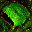

In [26]:
"""loader_targets = get_dataloader(batch_size=batch_size, split='val', augment=False)

for model_id, ckpt in enumerate(tqdm(ckpts)):

    traker.start_scoring_checkpoint(exp_name='quickstart',

                                    checkpoint=ckpt,

                                    model_id=model_id,

                                    num_targets=len(loader_targets.dataset))

    for batch in loader_targets:

        batch = [x.cuda() for x in batch]

        traker.score(batch=batch, num_samples=batch[0].shape[0])


scores = traker.finalize_scores(exp_name='quickstart')"""


dummy_dataset_path = "../generated_images/1"
seed = 1
generator = torch.Generator(device="cuda").manual_seed(seed)

dummy_dataset =  load_dataset('imagefolder', data_dir=dummy_dataset_path, split='train')

#Purely to keep consistent this with the source dataset
dummy_dataset = dummy_dataset.rename_column("image", "img")

dummy_dataset = dummy_dataset.map(convertLabel)

dummy_dataset = dummy_dataset.remove_columns(column_names=["label"])

print(dummy_dataset)
print(dummy_dataset[6]['label_txt'])
dummy_dataset[6]['img']

In [27]:
preprocessed_dummy_dataset = dummy_dataset.with_transform(preprocess_train)

dummy_dataloader = DataLoader(
    preprocessed_dummy_dataset,
    shuffle=False,
    collate_fn=collate_fn,
    batch_size=1,
)

In [28]:
UPDATE_SCORES = False

if UPDATE_SCORES:
    traker.start_scoring_checkpoint(exp_name='quickstart',

                                        checkpoint=ckpt,

                                        model_id=model_id,

                                        num_targets=len(dummy_dataloader.dataset))

    for batch in tqdm(dummy_dataloader):
            if CUDA:
                batch = [x.cuda() for y,x in batch.items()]
            else:
                batch = [x for y,x in batch.items()]
            image = batch[0]
            tokens = batch[1]
            # Convert images to latent space
            latents = vae.encode(image.to(weight_dtype)).latent_dist.sample()
            latents = latents * vae.config.scaling_factor
            encoder_hidden_states = text_encoder(tokens, return_dict=False)[0]

            batch = [latents, encoder_hidden_states]
            traker.score(batch=batch, num_samples=batch[0].shape[0])

    scores = traker.finalize_scores(exp_name='quickstart')

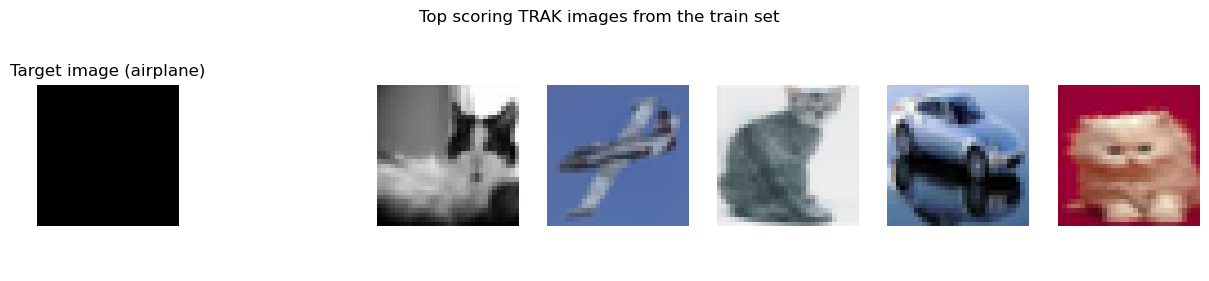

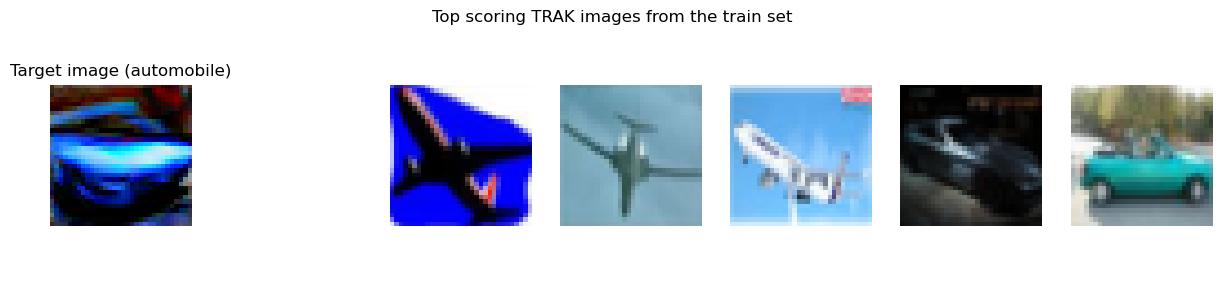

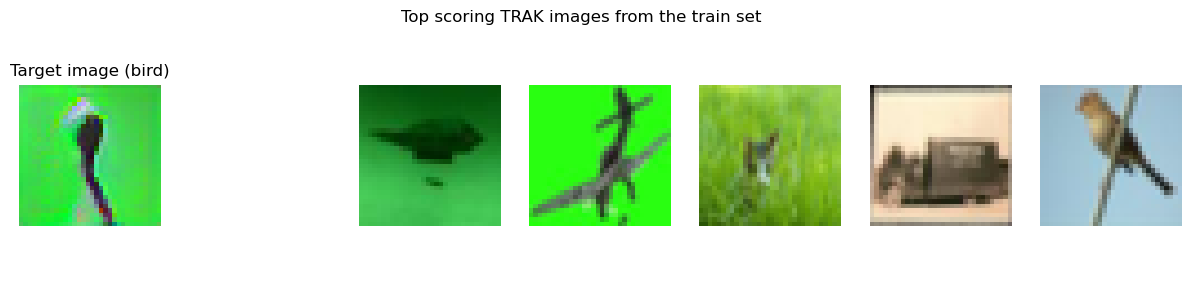

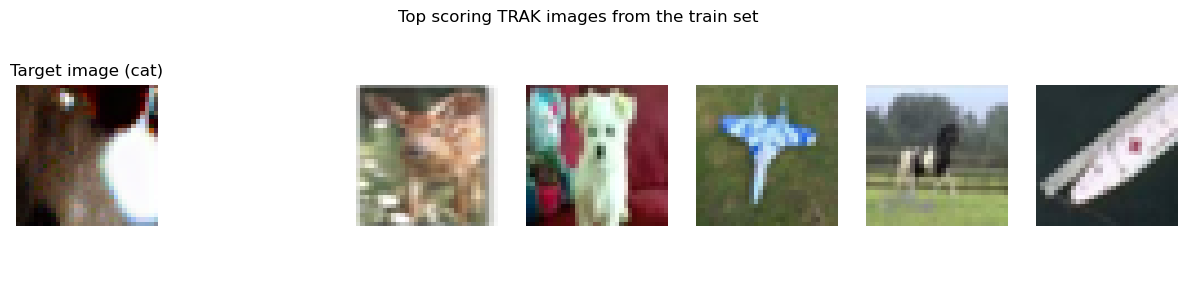

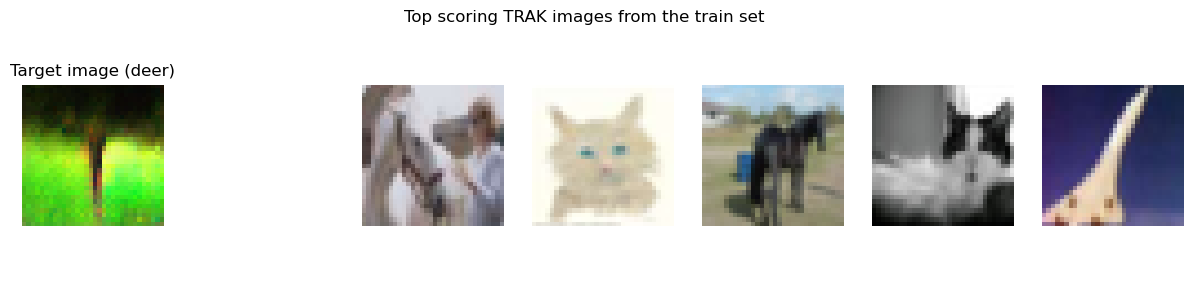

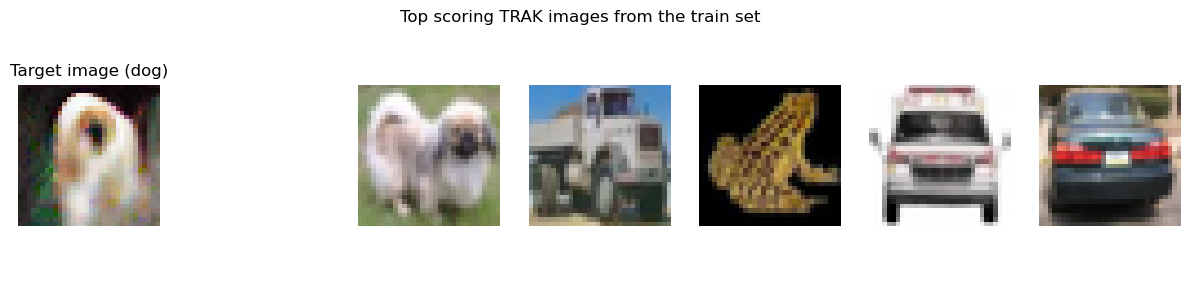

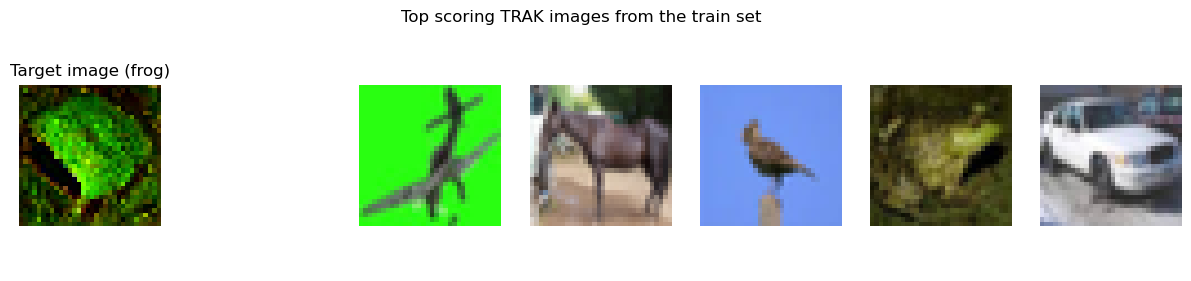

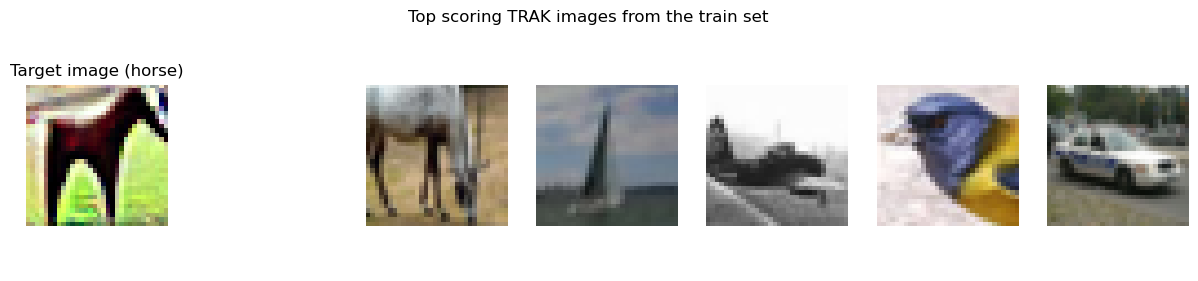

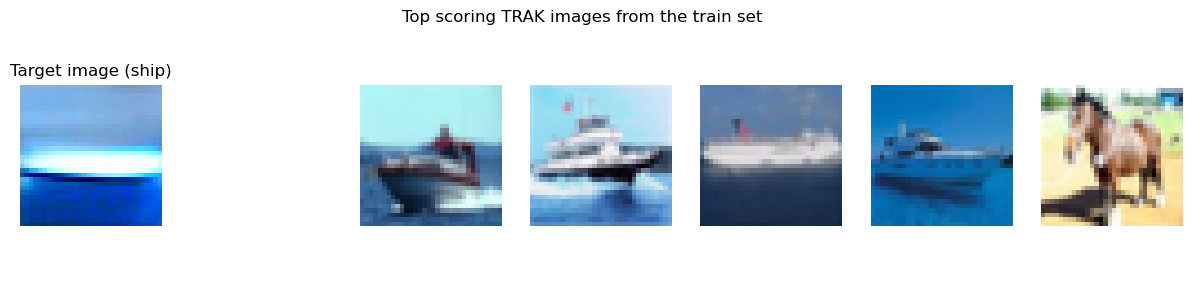

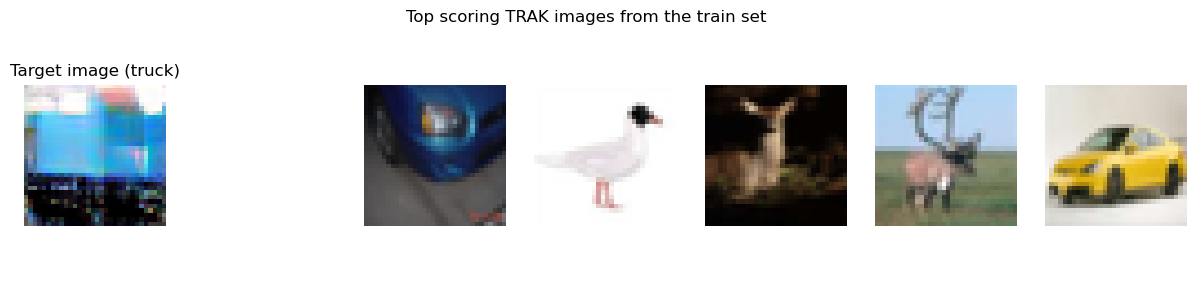

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

#Adapted from https://github.com/MadryLab/trak/blob/main/examples/cifar_quickstart.ipynb

from numpy.lib.format import open_memmap
scores = open_memmap('./trak_results/scores/quickstart.mmap')

for i in range(10): #[6]:

    fig, axs = plt.subplots(ncols=7, figsize=(15, 3))
    fig.suptitle('Top scoring TRAK images from the train set')
    
    axs[0].imshow(dummy_dataset[i]["img"])
    
    axs[0].axis('off'); axs[0].set_title('Target image' + " (" + dummy_dataset[i]["label_txt"] + ")")
    axs[1].axis('off')
    
    top_trak_scorers = scores[:, i].argsort()[-5:][::-1]
    for ii, train_im_ind in enumerate(top_trak_scorers):
        axs[ii + 2].imshow(train_dataset[int(train_im_ind)]["img"]); axs[ii + 2].axis('off')

    fig.show()